In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('ThesisResults.csv')

In [3]:
# Average the prediction time per approach and bits over all datasets
avg_pred_time = data.groupby(['Use Case', 'Approach', 'Bits'])['Prediction Time Sample'].mean().reset_index()
data['Avg prediction time per bit'] =  [avg_pred_time.loc[(avg_pred_time['Use Case'] == data['Use Case'][i]) & (avg_pred_time['Approach'] == data['Approach'][i]) & (avg_pred_time['Bits'] == data['Bits'][i])]['Prediction Time Sample'].values[0] for i in range(len(data))]

# Concrete slowdown compare to generic ML library
# where use case approach and dataset are the same
# caculate Bits=-1 prediction per sample time with other bit configurations
data['Concrete Slowdown'] = 0
for idx, row in data.iterrows():
    if row['Bits'] == -1:
        continue
    generic_time = data.loc[(data['Use Case'] == row['Use Case']) &
                            (data['Approach'] == row['Approach']) &
                            (data['Dataset'] == row['Dataset']) &
                            (data['Bits'] == -1)]['Prediction Time Sample'].values
    concrete_time = row['Prediction Time Sample']
    data.at[idx, 'Concrete Slowdown'] = int(concrete_time / generic_time)

# Sort data by Use Case, Approach, Dataset, Bits
data = data.sort_values(['Use Case', 'Approach', 'Dataset', 'Bits'])

In [4]:
# Background color
background_color = '#EAEAF2'
# Grid color
grid_color = 'white'
# Axis fontsize
ax_fontsize = 11

# Quantization X Prediction Time + Metrics

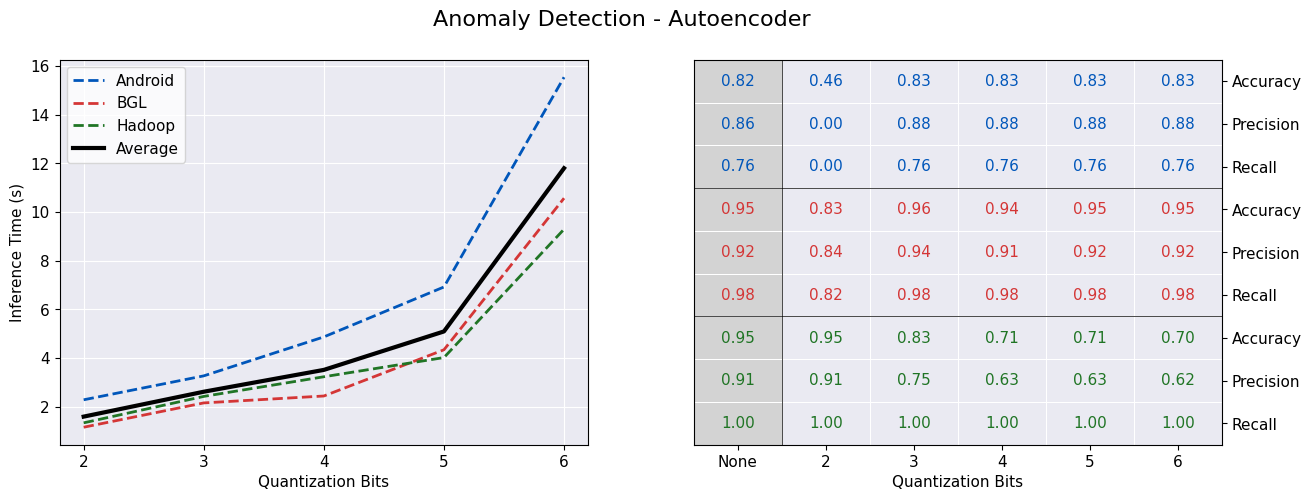

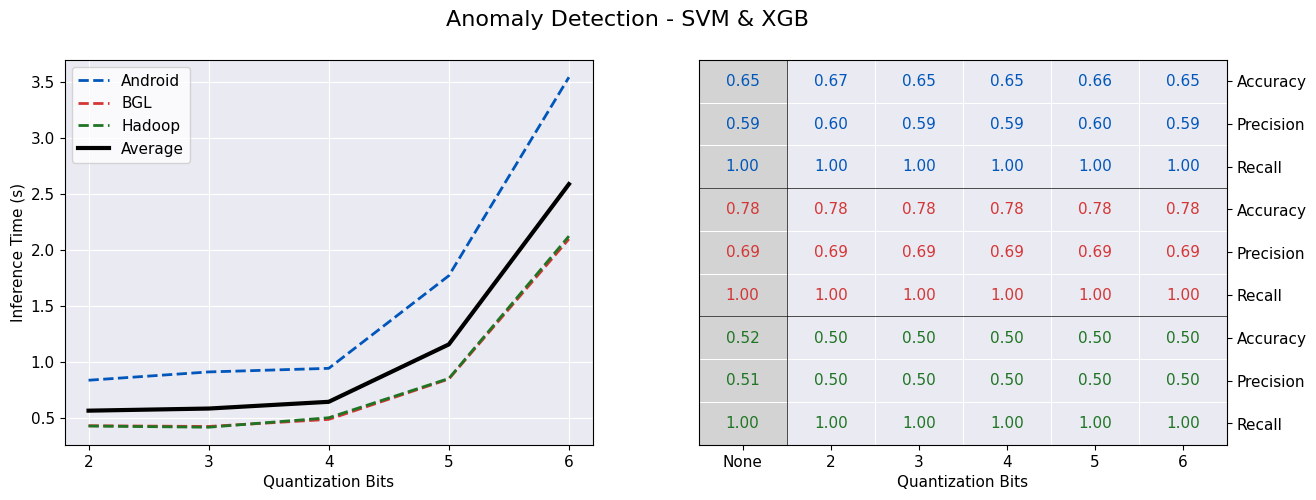

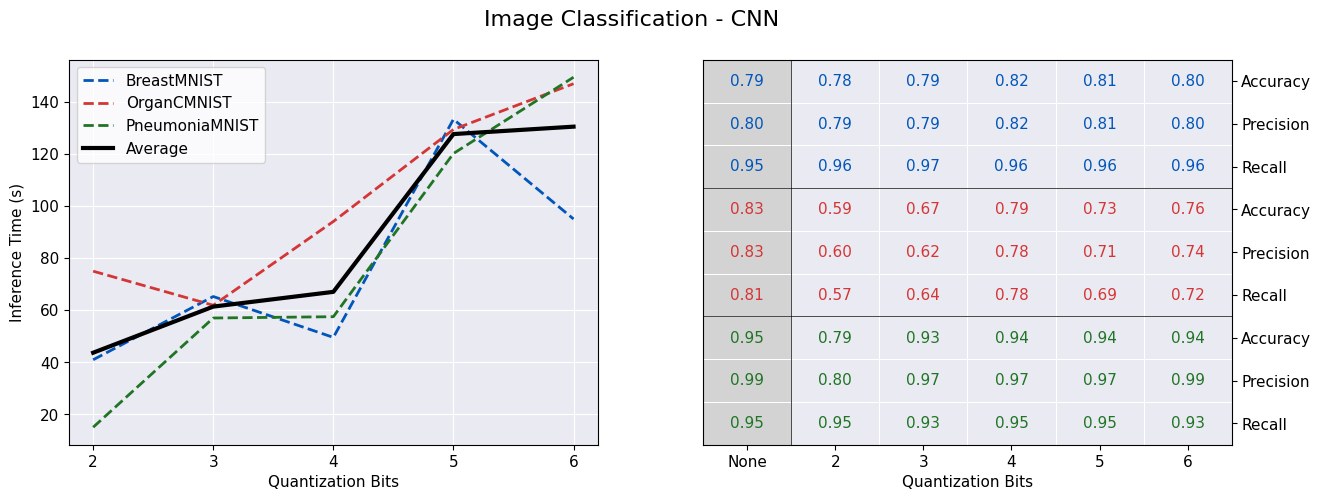

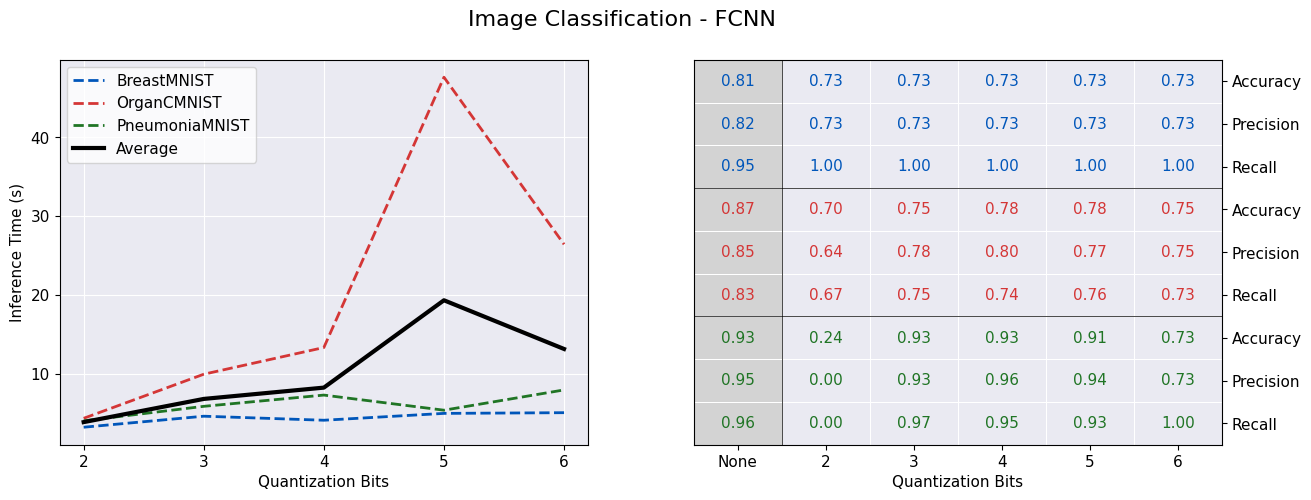

In [5]:
for idx, row in data[['Use Case', 'Approach']].drop_duplicates().iterrows():
    use_case = row['Use Case']
    approach = row['Approach']
    title = f'{use_case} - {approach}'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Set title
    plt.suptitle(title, fontsize=16)
    # Define color palette
    colors = ['#0056BA', '#D43636', '#207525']

    # Create subset of data
    subset = data[(data['Use Case'] == use_case) & (data['Approach'] == approach)]
    
    # Plot 1: Quantization X Prediction Time
    # Get FHE benchmarks
    fhe = subset[subset['FHE'] == True][['Dataset', 'Bits', 'Prediction Time Sample']].reset_index(drop=True)
    # Average FHE benchmarks grouped by Bits
    fhe_avg = fhe.groupby('Bits')['Prediction Time Sample'].mean().reset_index().reset_index(drop=True)
    # For each individual dataset in FHE plot x: Bits, y: compare_with
    individual_datasets = fhe['Dataset'].unique()
    for idx, dataset in enumerate(individual_datasets):
        dataset_subset = fhe[fhe['Dataset'] == dataset]
        # Plot individual dataset benchmarks
        sns.lineplot(x='Bits', y='Prediction Time Sample', data=dataset_subset, ax=axs[0], color=colors[idx], label=dataset, linestyle='--', linewidth=2)
    # Plot average FHE benchmarks
    sns.lineplot(x='Bits', y='Prediction Time Sample', data=fhe_avg, ax=axs[0], color='black', label='Average', linewidth=3)
    # X-ticks to Bits values (integers)
    axs[0].set_xticks(fhe_avg['Bits'].unique())
    # axs Fontsize
    axs[0].tick_params(axis='both', which='major', labelsize=ax_fontsize)
    # Y-label
    axs[0].set_ylabel('Inference Time (s)', fontsize=ax_fontsize)
    # X-label
    axs[0].set_xlabel('Quantization Bits', fontsize=ax_fontsize)
    # Legend fontsize
    axs[0].legend(fontsize=ax_fontsize)
    # Set background color
    axs[0].set_facecolor(background_color)
    # Set grid color
    axs[0].grid(color=grid_color)

    # Plot 2: Predicition Metrics
    # Create table
    metrics_tbl = subset[['Dataset', 'Bits', 'Accuracy', 'Precision', 'Recall']]
    # Create a pivot table
    metrics_tbl = metrics_tbl.pivot(index='Bits', columns='Dataset', values=['Accuracy', 'Precision', 'Recall'])
    # Swap levels
    metrics_tbl = metrics_tbl.swaplevel(axis=1).sort_index(axis=1)
    # Drop dataset level
    metrics_tbl.columns = metrics_tbl.columns.droplevel()
    # Transpose table
    metrics_tbl = metrics_tbl.T
    # Change column names
    metrics_tbl.columns = [str(int(x)) if x!=-1 else 'None' for x in metrics_tbl.columns]
    # Create a mask where only the first column is unmasked (False)
    mask = np.ones_like(metrics_tbl, dtype=bool)
    mask[:, 0] = False
    # Plot first column of the heatmap
    sns.heatmap(metrics_tbl, annot=True, fmt=".2f", cmap=['lightgrey'], cbar=False, linewidths=0.5, linecolor=grid_color, ax=axs[1], mask=mask)
    # Plot the rest of the heatmap
    sns.heatmap(metrics_tbl, annot=True, fmt=".2f", cmap=[background_color], cbar=False, linewidths=0.5, linecolor=grid_color, ax=axs[1], mask=~mask)
    # Annotations fontsize
    for text in axs[1].texts:
        text.set_fontsize(ax_fontsize)
    # Font color for the first three rows=colors[0], next three rows=colors[1], last three rows=colors[2]
    for text in axs[1].texts:
        row_index = int(text.get_position()[1])
        if row_index < 3:
            text.set_color(colors[0])
        elif row_index < 6:
            text.set_color(colors[1])
        else:
            text.set_color(colors[2])
    # black border for the heatmap
    for _, spine in axs[1].spines.items():
        spine.set_visible(True)
        spine.set_color('black')

    # Adding custom horizontal grid lines every third row
    for i in range(metrics_tbl.shape[0]):
        if (i+1) % 3 == 0:  # Every third row, draw a line below it
            axs[1].axhline(i + 1, color='black', linewidth=0.5)
    # Adding custom vertical grid line for first column
    axs[1].axvline(1, color='black', linewidth=0.5)
    # Y-labels to the right side
    axs[1].yaxis.tick_right()
    # Rotate y-labels for axs[1]
    plt.yticks(rotation=0)
    # axs Fontsize
    axs[1].tick_params(axis='both', which='major', labelsize=ax_fontsize)
    # X-label
    axs[1].set_xlabel('Quantization Bits', fontsize=ax_fontsize)
    # Set background color
    axs[1].set_facecolor(background_color)

    plt.show()

# Slowdown

In [6]:
sns.set_style('whitegrid')

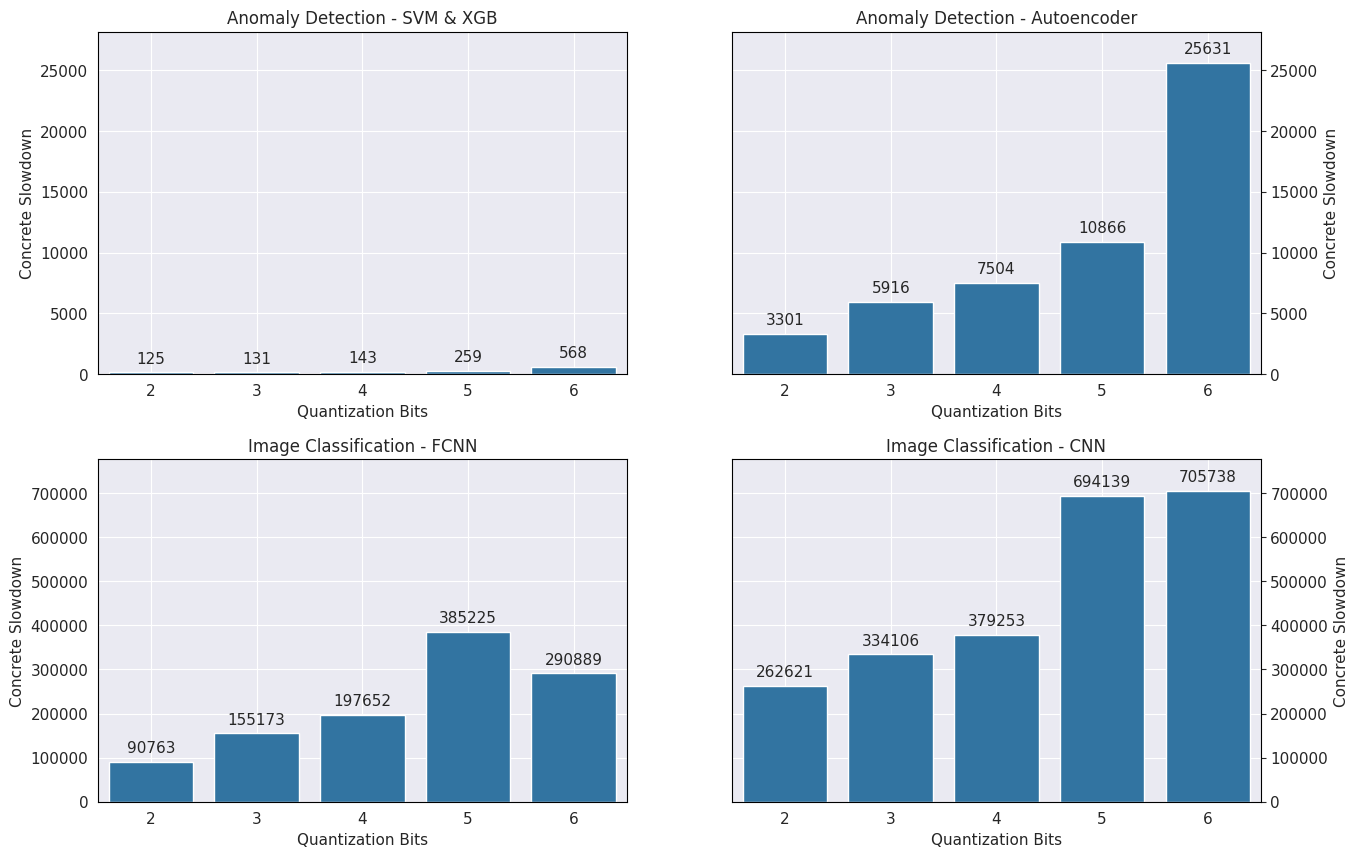

In [7]:
slowdown_data = data[['Use Case', 'Approach', 'Dataset', 'Bits', 'Concrete Slowdown']]
slowdown_data = slowdown_data.groupby(['Use Case', 'Approach', 'Bits'])['Concrete Slowdown'].mean().reset_index().sort_values(['Use Case', 'Approach', 'Bits'])
slowdown_data = slowdown_data[slowdown_data['Bits'] != -1]
slowdown_data['Bits'] = slowdown_data['Bits'].astype(int)
# Subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Vertical spacing
plt.subplots_adjust(hspace=0.25)
axs = axs.flatten()
order = {'SVM & XGB': 0, 'Autoencoder': 1, 'FCNN':2, 'CNN': 3}
# Barplot for each Use Case & Approach, x=Bits & y=Concrete Slowdown
for idx, row in slowdown_data[['Use Case', 'Approach']].drop_duplicates().iterrows():
    use_case = row['Use Case']
    approach = row['Approach']
    title = f'{use_case} - {approach}'
    subset = slowdown_data[(slowdown_data['Use Case'] == use_case) & (slowdown_data['Approach'] == approach)]
    sns.barplot(x='Bits', y='Concrete Slowdown', data=subset, ax=axs[order[approach]])
    # Add 10% margin over the highest bar
    axs[order[approach]].set_ylim(0, subset['Concrete Slowdown'].max() * 1.1)
    # Set title and axes labels
    axs[order[approach]].set_title(title)
    axs[order[approach]].set_xlabel('Quantization Bits', fontsize=ax_fontsize)
    axs[order[approach]].set_ylabel('Concrete Slowdown', fontsize=ax_fontsize)
    # axs Fontsize
    axs[order[approach]].tick_params(axis='both', which='major', labelsize=ax_fontsize)
    # If plot on the right side - move y-label and ticks to the right side
    if order[approach] % 2 != 0:
        axs[order[approach]].yaxis.tick_right()
        axs[order[approach]].yaxis.set_label_position('right')
    # Set background color
    axs[order[approach]].set_facecolor(background_color)
    # Set grid color
    axs[order[approach]].grid(color=grid_color)
    # Add value on top of each bar as integer
    # Make sure there is space to plot border
    for p in axs[order[approach]].patches:
        axs[order[approach]].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=ax_fontsize)
    # Black subplot border
    for _, spine in axs[order[approach]].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
    # for each row in the subplot. share the same y-axis
    if order[approach] % 2 == 0:
        axs[order[approach]].sharey(axs[order[approach] + 1])

plt.show()